<a href="https://colab.research.google.com/github/rubanzasilva/abalone_age_prediction/blob/dev/ps_s04e04_fastai_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72489%2F8096274%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T080434Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2e6860094c8d08ebd9a77014c82612a2d29a737971dfc1d7ca7596e842eddb667a179a5bd0bc8e9650de18f725e0225a0dc28e51b4dff4026f7421cac35fc2037289e5b5064df73201c524aa4c4e69f67d55878f000c6dbdbac6e74e203477350e6169ef50119eef759030ac93f06c00875efee36ca8edd79f8ff872ac631f5f1041c339ca464a014c6fdd5c573d430a7625db1971e2e03269ad1a8b37f24e47b3ef203d0e74e7fcbf1c08e4a3a4aa6ef94fb4f1e0c8777ac7709678d5412d4e2576c48d33d52e6bd420590f947149a72ce4532bbb77491cd767d80f32e955414b466fc26b3369fe63017e60694fc23f52fe797c4654da1c5fea8feeec4823a4,abalone-original-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4884752%2F8235698%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T080435Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D982d2fa212d5a38ddf86fe7e28d43aa27850ccc6cec8cbdaa71f979d41384e1f201fb1706b17bc3b014a65b48baac02985b9a722ec5f885e5088b7c697eb5a6ab5a11f79702cd82400214ece77a70a9a737b80c9df530f9cdc3811541cdb69a6a6a595ea78de24d6722063300ca0f2b4e711f799990e11afdbc822ce74d578a865c4cc04a0b199a826fb2ac007fc9852b09d57c85ceb9613b1cfd09ecc01c798434e9c9d13d446de759a696f50fc899f3169c7e03020d785411edefa22356dd3fa966b058a00d57bb89477db31652d9ec13285076216dcd6c5cfed2a862afd753c83fcba01906b8b58683fe82430fa5995719ec80d9acd073544c6f37b4657db'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


<a href="https://colab.research.google.com/github/rubanzasilva/abalone_age_prediction/blob/dev/ps_s04e04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abalone Age Prediction

Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).

### Imports

In [7]:
!pip install catboost
!pip install fastkaggle

In [9]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp

In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"3c109650146efc9c92fc9e8bfe70d487"}'}

In [15]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [16]:
comp = 'playground-series-s4e4'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 2.41M/2.41M [00:00<00:00, 119MB/s]

In [17]:
path

Path('playground-series-s4e4')

In [72]:
!ls playground-series-s4e4

abalone.csv  sample_submission.csv  test.csv  train.csv


In [ ]:
#set_seed(42)

In [71]:
path = Path('playground-series-s4e4/')
path

Path('playground-series-s4e4')

### Index_col

Removing the id column seems to slightly improve predictions so i go with a dataset with the id column set as the index.

In [78]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
original_df = pd.read_csv(path/'abalone.csv')

In [73]:
original_df = pd.read_csv(path/'abalone.csv')

In [74]:
original_df.shape,train_df.shape

((4177, 9), (90615, 9))

In [76]:
original_df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [75]:
train_df.columns,original_df.columns

(Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
        'Whole weight.2', 'Shell weight', 'Rings'],
       dtype='object'),
 Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
        'Viscera weight', 'Shell weight', 'Rings'],
       dtype='object'))

In [79]:
train=original_df.rename(columns={'Shucked weight':'Whole weight.1', 'Viscera weight':'Whole weight.2'})
test=original_df.rename(columns={'Shucked weight':'Whole weight.1', 'Viscera weight':'Whole weight.2'})

In [81]:
train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [82]:
train_df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


Import the original dataset from the UC Irvine Machine Learning Repository into kaggle using their ucimlrepo package.

In [70]:
# fetch dataset
abalone = fetch_ucirepo(id=1)

#path = playground-series-s4e4/abalone

#original_df = pd.read_csv(path,index_col='id')

#original_df = pd.DataFrame(abalone['data'], columns=abalone['names'])
#original_df.index.rename('id', inplace=True)


I import the abalone dataset from https://www.kaggle.com/code/aaachen/ps4e4-xgboost-lightgbm-catboost/input?select=abalone.csv as the file is already a csv. I shall try to manually import it from UCI later on.

# Model Architectures.

Below, i try out various models.

I have combined the steps for the different models in one codecell respectively, to see the breakdown, go through the breakdown section

In [24]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [25]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

# Neural Network

SuggestedLRs(slide=6.309573450380412e-07, valley=0.0063095735386013985)

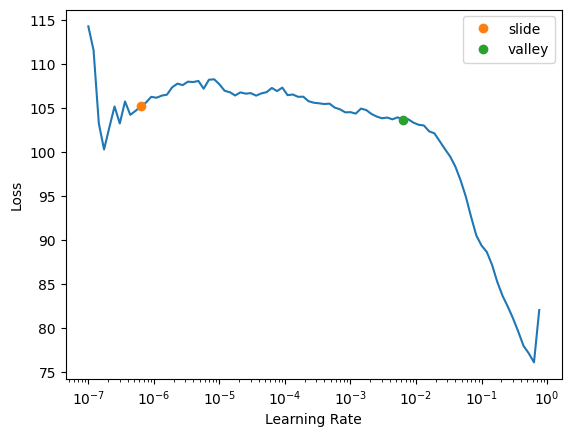

In [26]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

learn = tabular_learner(dls, metrics=rmse)
learn.lr_find(suggest_funcs=(slide,valley))

Neural Network Ensemble

The Neural network ensemble results in slighty better results.

In [27]:
learn.fit_one_cycle(10,0.005)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

epoch,train_loss,valid_loss,_rmse,time
0,4.103111,3.565827,1.888340,00:10
1,4.080494,3.640285,1.907953,00:10
2,3.972114,3.539315,1.881306,00:20
3,3.923566,3.534753,1.880094,00:13
4,3.803539,3.586935,1.893920,00:10
5,3.584623,3.510607,1.873661,00:10
6,3.610348,3.439203,1.854509,00:10
7,3.930802,3.413936,1.847684,00:10
8,3.800343,3.439312,1.854538,00:10
9,3.708214,3.410764,1.846825,00:10


1.1279778

In [ ]:
nn_preds_x.shape

In [28]:
dl = learn.dls.test_dl(test_df)
def ensemble():
  learn = tabular_learner(dls, metrics=mae)
  with learn.no_bar(), learn.no_logging():
    learn.fit(7, 0.005)
  return learn.get_preds(dl=dl)[0]

learns = [ensemble() for _ in range(5)]

In [29]:
ens_preds = torch.stack(learns).mean(0)

In [30]:
ens_preds_x = ens_preds.squeeze(1)
ens_preds_x.shape

torch.Size([60411])

In [ ]:
#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
#nn_preds_x.shape

In [ ]:
ens_preds.shape

In [ ]:
#ens_new = learn.get_preds(dl=dl)
#ens_new_preds, _ = learns.get_preds(dl=dl)
#final_ens_preds = ens_new_preds.squeeze(1)
#final_ens_preds

In [ ]:
#ens_preds = torch.stack(learns).mean(0)
#ens_target_preds = ens_preds
#test_df['Rings'] = ens_target_preds

#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
#mse = mean_absolute_error(y_test, ens_preds_y)
#rmse = np.sqrt(mse)
#rmse

# CATBOOST

In [31]:
cat_model = CatBoostRegressor(iterations=200, depth=6, learning_rate=0.3, random_strength=0.5)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)


cat_preds = tensor(cat_model.predict(test_dl.xs))

mse = mean_absolute_error(y_test, cat_model.predict(X_test))
rmse = np.sqrt(mse)
rmse

1.1126430393429967

In [ ]:
!ls

# XGBoost

In [32]:
model = xgb.XGBRegressor(n_estimators = 200, max_depth=7, learning_rate=0.08, subsample=0.5)
xgb_model = model.fit(X_train, y_train)
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)
xgb_preds = tensor(model.predict(test_dl.xs))

mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

1.1114287

# LightGBM

In [33]:
new_model = lgb.LGBMRegressor(num_leaves=50, learning_rate=0.16, n_estimators=200)
lgb_model = new_model.fit(X_train, y_train)


lgb_preds = tensor(new_model.predict(test_dl.xs))


mse = mean_absolute_error(y_test, new_model.predict(X_test))
rmse = np.sqrt(mse)
rmse

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 8
[LightGBM] [Info] Start training from score 9.702850


1.1092100946846497

# Random Forest

In [34]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

mse = mean_absolute_error(y_test, rf_model.predict(X_test))
rmse = np.sqrt(mse)
rmse

1.1257128796419238

In [41]:
lgb_preds.shape,xgb_preds.shape,cat_preds.shape,nn_preds_y.shape,ens_preds_x.shape

(torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]),
 torch.Size([60411]))

In [42]:
general_preds = ( xgb_preds + lgb_preds + cat_preds + ens_preds_x + rf_preds )/5
general_preds

tensor([ 9.5909,  9.5625,  9.9034,  ..., 12.2429, 13.5647,  8.3064])

In [ ]:
general_preds

In [ ]:
#adding ensemble preds
general_preds = ( xgb_preds + lgb_preds + cat_preds + final_ens_preds)/4
general_preds

In [35]:
#adding random forest preds
general_preds = ( xgb_preds + lgb_preds + cat_preds + nn_preds_y + rf_preds)/5
general_preds

tensor([ 9.6349,  9.5672,  9.9122,  ..., 12.3277, 13.5295,  8.2826])

In [46]:
!rm submission.csv

In [45]:
!ls

catboost_info  models		       playground-series-s4e4.zip  submission.csv
kaggle.json    playground-series-s4e4  sample_data


Find a way to test different variations of general_preds before kaggle submission.

# Submission

In [43]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,Rings
0,90615,9.590894
1,90616,9.562479
2,90617,9.903421
3,90618,10.278755
4,90619,7.682407
...,...,...
60406,151021,6.244174
60407,151022,9.389985
60408,151023,12.242919
60409,151024,13.564692


In [44]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgb_preds + lgb_preds + cat_preds + ens_preds_x + rf_preds"

100% 961k/961k [00:00<00:00, 1.85MB/s]
Successfully submitted to Regression with an Abalone Dataset

In [ ]:
!ls

catboost_info  models  submission.csv


# Breakdown

### Initial Exploratory Data Analysis

**Variable description from the initial UCI dataset repository**

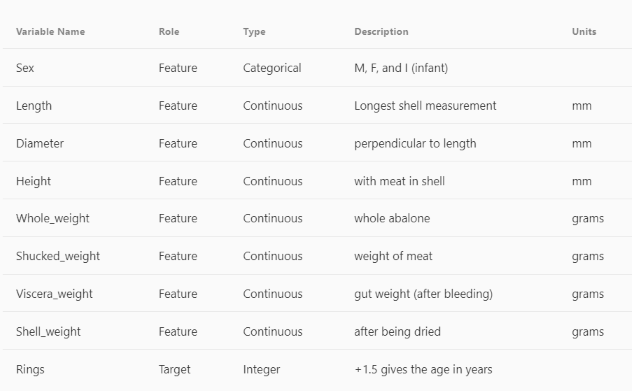


In [ ]:
train_df.head()

Categorical variable exploration

In [ ]:
train_df.describe(include=[object])

In [ ]:
train_df['Sex'].unique()

In [ ]:
train_df['Sex'].hist(figsize=(6,2));

In [ ]:
sex_classes_count = train_df['Sex'].value_counts()
sex_classes_count.plot(kind='pie',figsize=(10,4));

Sex has 3 values ??
Turns out Abalone's sex can change with time or over their lifespans.

The dataset categorises sex into 3 categories i.e. Male, Female and Infant.
We also notice that infant has the most values.

In [ ]:
train_df.describe()

In [ ]:
dep_classes_count = train_df['Rings'].value_counts()
dep_classes_count

In [ ]:
train_df['Rings'].hist()

In [ ]:
dep_classes_count = train_df['Diameter'].value_counts()
dep_classes_count

In [ ]:
train_df['Diameter'].hist()

In [ ]:
dep_classes_count.plot(kind='pie')

In [ ]:
train_df.hist(figsize=(20,15));

#### Feature Engineering

Drop Sex

In [ ]:
!ls

In [ ]:
train_df.drop('Sex', axis=1 , inplace=True)
test_df.drop('Sex', axis=1 , inplace=True)

### TabularPandas Object


We create an instance of a TabularPandas Object,to which is a fastai dataframe wrapper that stores all the information about our dataset such as which columns are continous, categorical, and our dependent variables.

This instance also stores and applies the set transformations to our data.

cont_cat_split helps us split our data into continuos and categorical variables.

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')

We split our data into training and validation with fastai's RandomSplitter which does an 80/20 random split.

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [ ]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

In [ ]:
to.xs.iloc[:2]

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
dls.show_batch()

In [ ]:
learn = tabular_learner(dls, metrics=rmse)

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit_one_cycle(10,0.02)

In [ ]:
#learn.fit_one_cycle(9,0.11)

In [ ]:
learn.show_results()

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
nn_preds = learn.get_preds(dl=dl)

In [ ]:
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

In [ ]:
nn_preds_x = learn.get_preds()[0]

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
learn = tabular_learner(dls, metrics=rmse)
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
#learn.fit_one_cycle(10,0.02)

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
#rmse(nn_preds_x, tensor(y_test))

In [ ]:
#rmse(nn_preds_x, tensor(y_test))

In [ ]:
!ls

In [ ]:
#target_preds = nn_preds[0]

In [ ]:
#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['id','Rings'], index=False)

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
ls

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 3 with id column + no random seed "

####Neural Network without id column

In [ ]:
target_preds = nn_preds[0]

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network Sub 7 with no id and sex column "

###Neural Network Ensemble

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy_multi, layers=[20,20,20,20], loss_func = BCEWithLogitsLossFlat())
    with learn.no_bar(),learn.no_logging():
        learn.fit(16, lr=0.07)
        learn.fit_one_cycle(10, slice(0.05, 0.05/5))
    return learn.get_preds(dl=tst_dl)[0]

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=rmse)
    with learn.no_bar(),learn.no_logging(): learn.fit(9, slice(1e-1,1e-3))
    return learn.get_preds(dl=dl)[0]

In [ ]:
#learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
ens_preds, _ = learn.get_preds(dl=dl)

In [ ]:
ens_preds_y = ens_preds.squeeze(1)
ens_preds_y

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
ens_preds_y[0]

In [ ]:
#target_preds = ens_preds_y[0]

#test_df['Rings'] = target_preds

#test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

#submission = pd.read_csv('submission.csv')
#submission.head()

In [ ]:
target_preds = ens_preds_y

test_df['Rings'] = target_preds

test_df.to_csv('submission.csv', columns=['Rings'], index=True, index_label='id')

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "Neural Network ensemble preds Sub 2 with no id column + no random seed "

In [ ]:
submission = pd.DataFrame({
     # Assuming 'Id' is the identifier column
    'target': ens_preds
})

# Save your submission to a CSV file
submission.to_csv('submission.csv', index=False)

In [ ]:
def subm(preds, suff):
    test_df['Rings'] = preds
    sub_df = test_df[['id','Rings']]
    sub_df.to_csv(f'sub{suff}.csv', index=False)

subm(ens_preds, 'mission')

In [ ]:
#sub_df = pd.DataFrame(ens_preds, columns='Rings')
#sub_df['id'] = test_df['id']

# Reorder the columns to match the submission format
#sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
#sub_df.to_csv('rf_submission.csv', index=False)

In [ ]:
#targets ='Rings'
#test_df[targets] = ens_preds
#sub_df['id'] = test_df['id']

#test_df.to_csv('submission.csv', columns=['Rings'], index=False)

#ens_sub = pd.read_csv('submission.csv')
#ens_sub.head()

### Random Forest

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

#cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
#to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                  # cat_names = cat_names,
                  # cont_names = cont_names,
                  # y_names='Rings',
                  # y_block=RegressionBlock(),
                  # splits=splits)

#X_train, y_train = to.train.xs, to.train.ys.values.ravel()
#X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)
#preds = (y_test, rf.predict(X_test))
rf_preds = tensor(rf_model.predict(test_dl.xs))


#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, rf_model.predict(X_test))
rmse = np.sqrt(mse)
rmse
#mean_absolute_error(y_test, rf.predict(X_test))

In [ ]:
!ls

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

In [ ]:
mse = mean_absolute_error(y_test, rf.predict(X_test))
rmse = np.sqrt(mse)
rmse

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

In [ ]:
#rf_preds = rf.predict(X_test)

In [ ]:
#rmse(rf_preds, tensor(y_test))

#### Feature Importance

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
rf_feat_importance(rf, X_train)

In [ ]:
fi = rf_feat_importance(rf, X_train)
fi[:10]

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [ ]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

In [ ]:
fi = rf_feat_importance(rf, X_train)
fi[:10]

#### Remove low importance variables

In [ ]:
to_keep = fi[fi.imp>0.05].cols
len(to_keep)


In [ ]:
to_keep

In [ ]:
X_imp = X_train[to_keep]
X_test_new = X_test[to_keep]

In [ ]:
rf.fit(X_imp, y_train);
#m = rf(X_imp, y)

In [ ]:
rf_preds = rf.predict(X_test_new)

In [ ]:
mse = mean_absolute_error(y_test, rf.predict(X_test_new))
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
#rf_preds = rf.predict(X_test_new)
#rmse(rf_preds, tensor(y_test))

In [ ]:
X_test

In [ ]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(rf, X_train)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

to_keep = fi[fi.imp>0.005].cols

In [ ]:
X_test_new


Shell weight and Whole weight seem to be the most importatant features closely followed by Whole Weight. 1 And Whole Weight. 2.

Sex seems to be the least important predictor.

In [ ]:
# Training dataset
numeric_columns_train = X_train.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

Darker Colors: Indicate stronger correlations. The closer the color is to the maximum intensity (e.g., red or orange for positive correlations, blue or green for negative correlations), the stronger the correlation 1.


Lighter Colors: Indicate weaker correlations. The closer the color is to the minimum intensity (e.g., white or light blue), the weaker the correlation 1.

Try dropping sex column.
or Diameter
or diameter and whole weight

In [ ]:
from fastai.tabular.all import cluster_columns

In [ ]:
cluster_columns(xs_imp)

####  Making Predictions

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
!ls

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
preds = tensor(rf.predict(test_dl.xs))
rf_preds = preds

In [ ]:
#rmse(rf_preds, tensor(y_test))

Kaggle submission code from


https://www.kaggle.com/code/nguyncaoduy/fastai-tabular-regression-model-nn-xgb



In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = rf_preds # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!rm submission.csv

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "random forest initial subm trial 3 with no id column in general model nb"

## XGBoost

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [ ]:
model = xgb.XGBRegressor(n_estimators = 200, max_depth=6, learning_rate=0.15, subsample=0.5)

In [ ]:
xgb_model = model.fit(X_train, y_train)

XGBoost Feature Importance

In [ ]:
plot_importance(xgb_model);

Similar to the random forest, sex seems to be the least important predictor.
Length seems to be the only differing facotr factor from the Random forst in importance.

In [ ]:
#xgb_preds = tensor(model.predict(X_test))

In [ ]:
#rmse(xgb_preds, tensor(y_test))

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
test_dl = dls.test_dl(test_df)

In [ ]:
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds

rmse with train set with sex column removed.

In [ ]:
xgb_preds

In [ ]:
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

In [ ]:
!ls

XGBoost Submission code

In [ ]:
X_train

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = xgb_preds # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!rm submission.csv

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost initial subm trial 5 without id column"

###General Model Ensemble

XGBoost + Random Forest

In [ ]:
avgs = (xgb_preds + rf_preds) / 2

In [ ]:
avgs = (xgb_preds + nn_preds_y) / 2

In [ ]:
avgs

In [ ]:
xgb_preds.shape,rf_preds.shape,nn_preds_y.shape

In [ ]:
avgs = (xgb_preds + nn_preds_y + rf_preds) / 3

In [ ]:
ens_preds_y

In [ ]:
avgs_ens = (xgb_preds + ens_preds_y + rf_preds) / 3

avgs_ens submission

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs_ens # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
avgs.shape

In [ ]:
!ls

avgs submission

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = avgs # nn_preds
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)

In [ ]:
!ls

In [ ]:
sub = pd.read_csv('submission.csv')
sub.head()

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "rf preds + xgb_preds sub 1 with no id column all adjustment to test set preds"

In [ ]:
!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds sub 1 with no id column all adjustment to test set preds"

In [ ]:
#!kaggle competitions submit -c playground-series-s4e4 -f submission.csv -m "xgboost preds, nn_preds + random forest preds sub 3 with no id column all adjustment to test set preds"

#### Full Notebook

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()
model = xgb.XGBRegressor(n_estimators = 200, max_depth=6, learning_rate=0.15, subsample=0.5)
xgb_model = model.fit(X_train, y_train)
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)
preds = tensor(model.predict(test_dl.xs))
xgb_preds = preds
submit = pd.read_csv(path/'sample_submission.csv')
submit['Rings'] = xgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, model.predict(X_test))
rmse = np.sqrt(mse)
rmse

In [ ]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Rings')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Rings',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

new_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=200)
lgb_model = new_model.fit(X_train, y_train)

#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

new_preds = tensor(new_model.predict(test_dl.xs))
lgb_preds = new_preds


#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Rings'] = xgb_preds
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
mse = mean_absolute_error(y_test, new_model.predict(X_test))
rmse = np.sqrt(mse)
rmse